In [1]:
from sedfitter.fit import Fitter
from sedfitter.extinction import Extinction
from sedfitter.source import Source
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import os

In [2]:
models = os.listdir('../data/galaxySEDs/')
if '.DS_Store' in models: models.remove('.DS_Store')
models = [x for x in models if 'norm' not in x]
print((models))

['SF_Type2_AGN_1', 'WeakPAH_SF_glx_1', 'Ly_break', 'Type2_AGN_1', 'Torus', 'Young_SF_glx', 'MIR_powlaw_SF_glx', 'SF_Type1_AGN_1', 'SF_glx_2', 'Si_break', 'Red_SF_glx_2', 'Type1_AGN_1', 'Spiral', 'PAH_SF_glx', 'Mod_SF_glx', 'Blue_SF_glx', 'SF_Type2_AGN_2', 'Elliptical', 'SF_Type2_AGN_3', 'WeakPAH_SF_glx_2', 'Type2_AGN_2', 'Obs_SF_glx', 'MIRex_SF_glx', 'SF_glx_1', 'SF_Type1_AGN_2', 'Red_SF_glx_1', 'BroadFIR_SF_glx', 'SF_Type1_AGN_3', 'SF_Type1_AGN_4', 'Secular_glx', 'Warm_SF_glx', 'Cold_glx']


In [3]:
extinction = Extinction.from_file('../data/raw/whitney.r550.par')

In [4]:
apertures = [2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 7.6] * u.arcsec

In [5]:
filters = ['2J', '2H', '2K', 'I1', 'I2', 'I3', 'I4', 'M1']
#filters = [1.235 * u.um, 1.662 * u.um, 2.159 * u.um, 3.6 * u.um, 4.5 * u.um, 5.8 * u.um, 8.0 * u.um, 23.675 * u.um]
filterpeaks = [1.235, 1.662, 2.159, 3.6, 4.5, 5.8, 8.0, 23.675]

In [6]:
from astropy.visualization import quantity_support
quantity_support()

sourcepath = '../data/raw/SESNA_normalized'
sourcefile = open(sourcepath,'r')
savables = pd.DataFrame(columns = ['ID', 'Model', 'Model Fluxes', 'Source Flux', 'Source Error', 'Valid', 'Chi^2', 'Chi^2 DOF', 'Av', 'Scale'])

leash = 10

while True: # This while loop will run through each Source in SESNA, breaking the loop when it reaches the EOF
    try: s = Source.from_ascii(sourcefile.readline())
    except EOFError: break

    for galmod in models: # This for loop goes through each of the 32 galaxy models and fits them to the current SESNA source
        fitter = Fitter(filters, apertures, '../data/galaxySEDs/'+galmod,
                extinction_law=extinction,
                distance_range=[0.8, 2] * u.kpc,
                av_range=[0, 40.], remove_resolved=True)
        
        info = fitter.fit(s)
        print(info.source.name + ' with ' + info.model_name[0])
        # Data to be saved (modelfluxes, chi2, chi2 deg of freedom,)
        modelflux = info.model_fluxes[0]
        chi2 = info.chi2[0]
        chi2_DOF = len([x for x in s.valid if x == 1])
        sourcename = info.source.name
        source = np.array(info.source.to_ascii().split()[11:-1:2]).astype(float) # Make sure this is pulling the correct values. We take 11 to the last value because first 3 indices are ID and ra/dec, followed by 8 valid numbers
        sourceerror = np.array(info.source.to_ascii().split()[12::2]).astype(float) # This grabs error
        mask = np.array([True if x == 1 else False for x in info.source.valid])
        fitav = info.av[0]
        fitsc = info.sc[0]
        modelname = info.model_name[0]
        savables.loc[len(savables.index)] = [sourcename, modelname, modelflux, source, sourceerror, mask, chi2, chi2_DOF, fitav, fitsc]

    if leash == 0:
        break
    else: leash-=1

#output = '../data/outputs/output_ngc2264_Ly_break2.fitinfo'
#fout = FitInfoFile(output,'w')
#info = info.keep(output_format)
#fout.write(info)
#fout.close()

sourcefile.close()

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  SF_Type2_AGN_1
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(1, 8).  use_memmap=True
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/2J.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/2H.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/2K.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I1.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I2.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I3.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I4.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/M1.fits
J033021.04+582049.3 with SF_Type2_AGN_1
 -----------------------------------------

## Fit with all models in the same directory

In [6]:
sourcecatalog = pd.read_pickle('../data/raw/SESNA_INPUTS_SourceID-Catalog_JakeJuly18.pkl')
sourcecatalog.set_index('ID',inplace=True)


In [11]:
sourcecatalog.loc['J033021.04+582049.3'][['DistMin','DistMax']].values

array([0.64, 0.96], dtype=object)

In [12]:
sourcecatalog

,Catalog,row,DistMin,DistMax,DistUnit
ID,,,,,
J033021.04+582049.3,AFGL 490,1,0.6400,0.9600,kpc
J032839.47+582051.7,AFGL 490,2,0.6400,0.9600,kpc
J032940.82+582053.3,AFGL 490,3,0.6400,0.9600,kpc
J032539.46+582059.2,AFGL 490,4,0.6400,0.9600,kpc
J032908.84+582101.5,AFGL 490,5,0.6400,0.9600,kpc
...,...,...,...,...,...
J222752.84+642612.9,S140,80200,0.6112,0.9168,kpc
J222759.59+642615.4,S140,80201,0.6112,0.9168,kpc
J222755.73+642636.7,S140,80202,0.6112,0.9168,kpc


In [9]:
dmin = sourcecatalog.query('ID == "J032940.82+582053.3"')[['DistMin','DistMax']].values[0]
dmin

array([0.64, 0.96])

In [48]:
from astropy.visualization import quantity_support
from itertools import islice
quantity_support()

sourcepath = '../data/raw/SESNA_normalized'
sourcefile = open(sourcepath,'r')

#savables = pd.DataFrame(columns = ['ID', 'Model', 'Model Fluxes', 'Source Flux', 'Valid', 'Chi^2', 'Chi^2 DOF', 'Av', 'Scale'])
rowlist = []

startindex = 0
endindex = 1000
numfits = endindex - startindex + 1 # Think 0 to 10 is 11 fits if we include both 0 and 10
index = startindex

sourcecatalog = pd.read_pickle('../data/raw/SESNA_INPUTS_SourceID-Catalog_JakeJuly18.pkl')
sourcecatalog = sourcecatalog.iloc[startindex:endindex+1]
sourcecatalog.set_index('ID',inplace=True)

for line in islice(sourcefile,startindex,endindex+1): # This while loop will run through each Source in SESNA, breaking the loop when it reaches the EOF
    try: s = Source.from_ascii(line)
    except EOFError: break

    #distances = sourcecatalog.query('ID == @s.name')[['DistMin','DistMax']].values[0] # Query sourcecatalog for the min and max distances
    distances = sourcecatalog.loc[s.name][['DistMin','DistMax']].values

    fitter = Fitter(filters, apertures, '../data/galaxtemps2',
            extinction_law=extinction,
            distance_range=distances * u.kpc,
            av_range=[0, 100.], remove_resolved=True)
    
    info = fitter.fit(s)
    info.keep(('N',10))
    if ((index-startindex) % 5) == 0:
        time = pd.Timestamp.now()
        print(f"Fitting source at index:{index:10.0f} at time: {time}")
    # Data to be saved (modelfluxes, chi2, chi2 deg of freedom,)
    modelflux = info.model_fluxes
    chi2 = info.chi2
    chi2_DOF = len([x for x in s.valid if x == 1])
    sourcename = info.source.name
    source = np.array(info.source.to_ascii().split()[11:-1:2]).astype(float) # Make sure this is pulling the correct values. We take 11 to the last value because first 3 indices are ID and ra/dec, followed by 8 valid numbers
    sourceerror = np.array(info.source.to_ascii().split()[12::2]).astype(float) # This grabs error
    mask = np.array([True if x == 1 else False for x in info.source.valid])
    fitav = info.av
    fitsc = info.sc
    modelname = info.model_name
    row = pd.DataFrame(columns = ['ID', 'Model', 'Model Fluxes', 'Source Flux', 'Valid', 'Chi^2', 'Chi^2 DOF', 'Av', 'Scale'])
    row.loc[len(row.index)] = [sourcename, modelname, modelflux, source, mask, chi2, chi2_DOF, fitav, fitsc]
    rowlist.append(row)

    if index < endindex: # We check exclusively less than because we check after the fit happens, so the last fit when index = endindex has already happened
        index += 1
    else:
        break

savables = pd.concat(rowlist,ignore_index=True)

#output = '../data/outputs/output_ngc2264_Ly_break2.fitinfo'
#fout = FitInfoFile(output,'w')
#info = info.keep(output_format)
#fout.write(info)
#fout.close()

sourcefile.close()

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  galaxtemps2
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(32, 8).  use_memmap=True
   Reading ../data/galaxtemps2/convolved/2J.fits
   Reading ../data/galaxtemps2/convolved/2H.fits
   Reading ../data/galaxtemps2/convolved/2K.fits
   Reading ../data/galaxtemps2/convolved/I1.fits
   Reading ../data/galaxtemps2/convolved/I2.fits
   Reading ../data/galaxtemps2/convolved/I3.fits
   Reading ../data/galaxtemps2/convolved/I4.fits
   Reading ../data/galaxtemps2/convolved/M1.fits
Fitting source at index:         0 at time: 2024-07-24 23:06:46.850159
 ------------------------------------------------------------
  => Model parameters
 ----------------------------------------

In [21]:
print(info.source.valid)
mask = np.array([True if x == 1 else False for x in info.source.valid])
print(mask)
print(np.array(info.source.to_ascii().split()[11:-1:2]).astype(float)[mask])
print(np.array(info.source.to_ascii().split()[11:-1:2]).astype(float)[~mask])

[1 1 1 1 1 1 3 3]
[ True  True  True  True  True  True False False]
[0.7576 1.     1.084  0.5046 0.3582 0.25  ]
[0.4543 4.075 ]


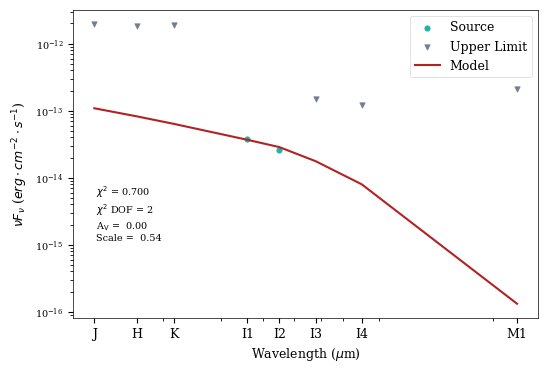

In [59]:
from astropy.visualization import quantity_support
quantity_support()

sourcenum = 47
modelnum = 0

modellogfluxes = savables['Model Fluxes'][sourcenum][modelnum]
filterpeaks = [x for x in filterpeaks] * u.um
modelflux = 10**(modellogfluxes) * u.mJy
modelfluxdens = modelflux.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))
sourceflux = savables['Source Flux'][sourcenum]
sourceflux = sourceflux * u.mJy
sourcefluxdens = sourceflux.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))

#sourceerror = savables['Source Error'][sourcenum]
#sourceerror = sourceerror * u.mJy
#sourcerrordens = sourceerror.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))

mask = savables['Valid'][sourcenum]

plt.figure(figsize=(6,4))
plt.scatter(filterpeaks[mask], sourcefluxdens[mask], c = 'lightseagreen',label = 'Source',s = 15) # Prints true values of the source
plt.scatter(filterpeaks[~mask], sourcefluxdens[~mask], c = 'slategray',label = 'Upper Limit', marker = 'v', s=15) # Prints upper limits of the source as triangles
plt.plot(filterpeaks, modelfluxdens, color='firebrick', label = 'Model')
#plt.errorbar(filterpeaks[mask], sourcefluxdens[mask], yerr=sourcerrordens[mask], linestyle='', c='lightseagreen')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength ' + '($\mu$m)',fontsize='9')
plt.ylabel('$\\nu F_{\\nu}$ ' + '($erg \cdot cm^{-2} \cdot s^{-1}$)',fontsize='9')
plt.xticks(filterpeaks, ['J', 'H', 'K', 'I1', 'I2', 'I3', 'I4', 'M1'],fontsize='9')
#plt.title('Fit: ' + savables['ID'][sourcenum]+ ' to ' + savables['Model'][sourcenum][modelnum])
plt.text(0.05,0.25, "$\chi^2$ = %5.3f   \n$\chi^2$ DOF = %1.0f   \nA$_{\\rm V}$ = %5.2f   \nScale = %5.2f" % 
         (savables['Chi^2'][sourcenum][modelnum], savables['Chi^2 DOF'][sourcenum], savables['Av'][sourcenum][modelnum], savables['Scale'][sourcenum][modelnum]),
         transform=plt.gca().transAxes,size='x-small')
plt.legend(fontsize='9')


In [54]:
from astropy.io import fits 

In [52]:
def retrieve_convolved_fluxes(model):
    convolvedflux = []
    for filt in filters:
        with fits.open('../data/galaxySEDS/'+model+'/convolved/'+filt+'.fits') as hdul:
            data = hdul[1].data
            convolvedflux.append(data[0][1][0])
    return np.array(convolvedflux)

In [ ]:
modelnum = 0

sourceflux = savables['Source Flux'][modelnum]
mask = savables['Valid'][modelnum]

    #convflux = retrieve_convolved_fluxes(model)
    #convflux = convflux / convflux[1] * u.mJy # normalize to H band
    #plt.figure()
    #plt.plot(filterpeaks,convflux)
    #plt.scatter(filterpeaks[mask],sourceflux[mask])
    #plt.scatter(filterpeaks[~mask],sourceflux[~mask],marker = 'v')
    #plt.title(model + ' with ' + savables['ID'][modelnum])
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Model Comparison')

for i, model in enumerate(models):
    convflux = retrieve_convolved_fluxes(model)
    convflux = convflux / convflux[1] * u.mJy # normalize to H band
    row = i // 8
    col = i % 8
    axs[row, col].plot(filterpeaks, convflux)
    axs[row, col].scatter(filterpeaks[mask], sourceflux[mask])
    axs[row, col].scatter(filterpeaks[~mask], sourceflux[~mask], marker='v')
    axs[row, col].set_title(model + ' with ' + savables['ID'][modelnum])
    axs[row, col].set_xscale('log')
    axs[row, col].set_yscale('log')

plt.tight_layout()
plt.show()


In [57]:
savables[savables['Chi^2 DOF'] == 2]

,ID,Model,Model Fluxes,Source Flux,Valid,Chi^2,Chi^2 DOF,Av,Scale
22,J032623.45+582152.7,"[MIRex_SF_glx, Red_SF_glx_1, Ly_break, BroadFI...","[[-8.186167445331819, -4.8333090334378275, -2....","[0.8169, 1.0, 1.36, 0.2227, 0.07923, 2.837, 0....","[False, False, False, True, False, False, Fals...","[2e+30, 2e+30, 2e+30, 2e+30, 2e+30, 2e+30, 2e+...",2,"[64.11719005941383, 78.45338228014096, 40.1276...","[-0.3322748770541399, -0.5640332425571916, 0.0..."
34,J032603.13+582212.4,"[WeakPAH_SF_glx_2, Red_SF_glx_1, Obs_SF_glx, L...","[[-12.572882365953399, -7.343078658743199, -4....","[0.8169, 1.0, 1.36, 0.1413, 0.2698, 0.2955, 0....","[False, False, False, True, False, False, Fals...","[3.0000000000000003e+30, 3.0000000000000003e+3...",2,"[100.0, 100.0, 100.0, 63.11615283721071, 100.0...","[-0.5914697567989291, -0.712650828001873, -0.7..."
36,J032645.19+582213.1,"[WeakPAH_SF_glx_2, Red_SF_glx_1, Obs_SF_glx, L...","[[-0.17296842762496029, -0.1515239877369598, -...","[1.203, 1.0, 1.36, 0.5942, 0.2634, 0.3383, 0.3...","[True, False, False, True, False, False, False...","[3.0000000000000003e+30, 3.0000000000000003e+3...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.21990630541575926, 0.08971352250380848, 0.0..."
41,J032618.15+582216.9,"[WeakPAH_SF_glx_2, Red_SF_glx_1, Obs_SF_glx, L...","[[-0.7324442468248529, -0.7109998069368524, -0...","[0.3201, 1.0, 1.36, 0.1788, 0.08244, 0.303, 0....","[True, False, False, True, False, False, False...","[1e+30, 1e+30, 1e+30, 1e+30, 1e+30, 1e+30, 1e+...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.49964421501570555, 0.3689488991306365, 0.35..."
47,J032625.09+582220.8,"[Torus, Red_SF_glx_2, Si_break, Type2_AGN_1, S...","[[-1.3491259962070192, -1.340874478195926, -1....","[0.8169, 1.0, 1.36, 0.04604, 0.03854, 0.2901, ...","[False, False, False, True, True, False, False...","[0.6999350866488119, 0.7110459770594142, 0.720...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5408544167751176, 0.60390587539688, 0.56885..."
...,...,...,...,...,...,...,...,...,...
993,J032814.22+582632.2,"[Torus, Red_SF_glx_2, Si_break, Type2_AGN_1, S...","[[-1.2627589481218782, -1.254507430110785, -1....","[0.8169, 1.0, 1.36, 0.05675, 0.04711, 0.2323, ...","[False, False, False, True, True, False, False...","[1.4129324699052996, 1.4350189736155956, 1.452...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.49767089273254705, 0.5607411456591437, 0.52..."
994,J032731.73+582632.2,"[Torus, Red_SF_glx_2, Si_break, Type2_AGN_1, S...","[[-0.9228216888113384, -0.9145701708002453, -0...","[0.8169, 1.0, 1.36, 0.1306, 0.09422, 0.2441, 0...","[False, False, False, True, True, False, False...","[18.325388230454195, 18.479996221864617, 18.60...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3277022630772772, 0.39078242520329165, 0.35..."
996,J032708.75+582632.4,"[Torus, Red_SF_glx_2, Si_break, Type2_AGN_1, S...","[[-1.2187848983743415, -1.2105333803632483, -1...","[0.8169, 1.0, 1.36, 0.0621, 0.05139, 0.2388, 0...","[False, False, False, True, True, False, False...","[1.3703056262612952, 1.3910869628834075, 1.407...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4756838678587787, 0.5387341855089591, 0.503..."
998,J032801.00+582632.6,"[Torus, Red_SF_glx_2, Si_break, Type2_AGN_1, S...","[[-1.1878339537040312, -1.179582435692938, -1....","[0.8169, 1.0, 1.36, 0.06638, 0.05889, 0.3212, ...","[False, False, False, True, True, False, False...","[0.48976866325900725, 0.5028802279594524, 0.51...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4602083955236235, 0.5232916121144808, 0.488..."


In [37]:
savables['Source Flux'][998][0]

0.8169

In [12]:
savables[savables['ID'] == 'J032637.84+582215.7'].loc[1247]['Source Error']

array([0.05807, 0.09348, 0.08924, 0.01416, 1.     , 1.     , 1.     ,
       1.     ])

In [144]:
# savables['Source Obj'][modelnum].flux
sourceflux = np.array(savables['Source Obj'][45].to_ascii().split()[11:-1:2]).astype(float)
sourceflux = sourceflux * u.mJy
sourcefluxdens = sourceflux.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))
print(sourcefluxdens[1])

1.803805403128761e-12 erg / (s cm2)


In [14]:
# Time to fit all of SESNA
3 * 5645590 / 60 / 60 / 24

196.02743055555558

In [15]:
6.5 / 10 * 5645590 / 60 / 60 / 24 # answer in days

42.4726099537037

In [43]:
# Current Speeds (made worse by saving more columns) (not all models together)
8.5 / 10 * 5645590 / 60 / 60 / 24 # answer in days

55.541105324074074

In [47]:
# Current Speeds (all models together)
.2 / 10 * 5645590 / 60 / 60 / 24 # answer in days

1.306849537037037

In [54]:
7*60/10000 *5645590 / 60 / 60 / 24

2.744384027777778

In [13]:
5645590 / 10 * 18.5 / 1000 / 60 / 60

2.9012059722222223

In [94]:
5645590 / 10 * 4.5 / 100 / 60 / 60

7.0569875

In [20]:
5645590 / 10 * 3 / 100 / 60 / 60

4.704658333333333

In [25]:
(3 * 60 + 10) / 10000 * 5645590 / 10 / 60 / 60

2.979616944444444